In [1]:
IRdisplay::display_html(file='code_hiding.html')

Toggle ON/OFF 
code cells.

In [2]:
# USEFUL COMMAND!
# example(data.table)

In [3]:
# load packages and define constants
library(data.table) # see https://cran.r-project.org/web/packages/data.table/vignettes/datatable-intro.html for reference
library(ggplot2)
source("R_functions.r")

# folder/file-specific constants
PILOT_NUMBER <- 6
DATA_FOLDER <- "~/programing/data/psychophys/"
FIRA_TAG <- "FIRA"
FRAMES_TAG <- "framesInfo"
DOTS_TAG <- "dotsPositions"

# key-specific constants 
TRIALS <- "trials"
FRAMES <- "frames"
DOTS <- "dots"

# plot-specific constants
AXES_LABEL_FONT <- 18
AXES_FONT <- 15

In [4]:
# load csv files into data.tables
tb <- list(
    loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, FIRA_TAG),
    loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, FRAMES_TAG),
    loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, DOTS_TAG))
names(tb) <- c(TRIALS, FRAMES, DOTS)

# add a trialCount column to the TRIALS table
tb[[TRIALS]][,trialCount:=.I]
# add trialIndex to the DOTS table
tb[[DOTS]] <- tb[[DOTS]][tb[[TRIALS]][,.(trialCount, trialIndex)],on="trialCount"]
str(tb[[DOTS]])

Classes ‘data.table’ and 'data.frame':	43862 obs. of  7 variables:
 $ xpos      : num  0.7459 0.5048 0.8971 0.3443 0.0796 ...
 $ ypos      : num  0.2885 0.8416 0.5606 0.5963 0.0589 ...
 $ isActive  : int  1 0 0 1 0 0 1 0 0 1 ...
 $ isCoherent: int  1 0 0 1 0 0 1 0 0 1 ...
 $ frameIdx  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ trialCount: int  1 1 1 1 1 1 1 1 1 1 ...
 $ trialIndex: int  6 6 6 6 6 6 6 6 6 6 ...
 - attr(*, ".internal.selfref")=<externalptr> 


# Notebook's goals

Make sure the workflow from running the task to analyzing the data works.

# A word on the data for this notebook
The tag for this data is `Pilot 6`. It was collected in the psychophysics booth with [this code](https://github.com/TheGoldLab/SingleCP_DotsReversal_Task/releases/tag/pilot6.mat).


# Workflow description
1. Task is run with repo [SingleCP_DotsReversal_Task](https://github.com/TheGoldLab/SingleCP_DotsReversal_Task/) (appropriate branch must be chosen).
  1. A `.mat` data file is outputted
  2. I usually manually rename this file `pilot_#.mat` and upload it to PennBox (Data/Psychophysics/Radillo_SingleCP_DotsReversal/)
2. Data is analyzed with repo [SingleCP_DotsReversal_DataAnalaysis](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis)(again, with the appropriate branch).
  1. The first step is to convert data from the .mat file into CSV format with [this script](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/blob/02109ab98b956f2aad4ac15f01e1d373260c8af0/MATLAB_scripts/mat2csv.m) 
    - `pilot#_framesInfo.csv` [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-description-of-*framesInfo.csv-file).
    - `pilot#_FIRA.csv`  [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-Description-of-*FIRA.csv-files).
    - `pilot#_dotsPositions.csv` [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-descriptions-for-*dotsPositions.csv-file).

**TO-DO**
- Write detailed explanation of each column in each `.csv` file (i.e. update the [Wiki](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki))
- Make sure data from the three `.csv` files is consistent

# Specific questions
1. How many frames are skipped on each trial, and where in the trial do they occur?
2. Does this number match the offset in viewing duration per trial?
3. Compute reverse kernels with the number of coherent dots as a proxy for motion energy

# Exploring the data
## The `*FIRA.csv` file (trials level)

In [5]:
# for this particular dataset, the timestamps of most columns have the wrong offset. This bug has been fixed since.
# for now, we still need to manually correct the time values as follows:
wideTimestamps <- tb[[TRIALS]][,.(trialStart=trialStart-trialStart,
                                       trialEnd=trialEnd-trialStart,
                                       dotsOn=dotsOn-2*trialStart,
                                       dotsOff=dotsOff-2*trialStart,
                                       targetOn=targetOn-2*trialStart,
                                       fixationOn=fixationOn - 2*trialStart,
                                       choiceTime=choiceTime-2*trialStart),by=trialIndex]
str(tb[[TRIALS]])

Classes ‘data.table’ and 'data.frame':	18 obs. of  26 variables:
 $ taskID         : int  2 2 2 2 2 2 2 2 2 2 ...
 $ trialIndex     : int  6 9 12 14 1 15 4 17 11 10 ...
 $ trialStart     : num  805061 805066 805071 805076 805081 ...
 $ trialEnd       : num  805066 805071 805076 805081 805085 ...
 $ RT             : num  1.222 1.223 1.1 0.703 1.228 ...
 $ choice         : int  1 0 0 0 0 1 0 1 1 0 ...
 $ correct        : int  1 0 0 1 1 0 1 1 1 0 ...
 $ initDirection  : int  0 0 0 0 180 180 180 180 0 0 ...
 $ endDirection   : int  0 0 0 180 180 180 180 0 0 0 ...
 $ presenceCP     : int  0 0 0 1 0 0 0 1 0 0 ...
 $ coherence      : num  25.6 12.8 25.6 6.4 6.4 12.8 12.8 25.6 25.6 12.8 ...
 $ viewingDuration: num  0.1 0.2 0.2 0.3 0.1 0.3 0.1 0.3 0.2 0.2 ...
 $ probCP         : num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...
 $ timeCP         : num  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 ...
 $ randSeedBase   : int  7597 9958 1108 5553 2607 9306 2457 859 8670 7918 ...
 $ fixationOn     : num

A deeper look at the timestamps fields

In [6]:
refTime <- wideTimestamps[,.(
    refTime=min(trialStart, trialEnd, dotsOn, dotsOff, targetOn, choiceTime),
    trialStart, trialEnd, dotsOn, dotsOff, targetOn, fixationOn, choiceTime), 
                        by=trialIndex]
longTimestamps <- melt(refTime,
                       id.vars=c("trialIndex"),
                       measure.vars=c("trialStart","fixationOn","targetOn","dotsOn","dotsOff",
                                      "choiceTime","trialEnd"),
                       value.name="timestamp", variable.name="Event")
str(longTimestamps)

Classes ‘data.table’ and 'data.frame':	126 obs. of  3 variables:
 $ trialIndex: int  6 9 12 14 1 15 4 17 11 10 ...
 $ Event     : Factor w/ 7 levels "trialStart","fixationOn",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ timestamp : num  0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 


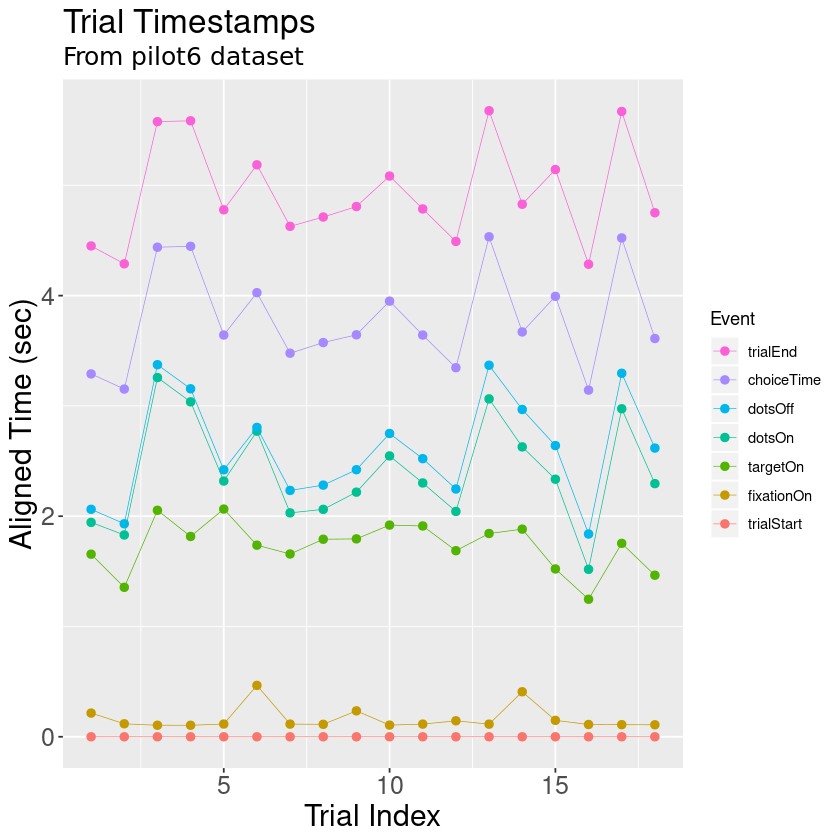

In [7]:
# plot
ggplot(longTimestamps, aes(x=trialIndex, y=timestamp)) + geom_point(aes(col=Event), size=2) +
   geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
    guides(colour = guide_legend(reverse=T)) +
    labs(title="Trial Timestamps",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="Aligned Time (sec)",
         x="Trial Index") + theme(plot.title=element_text(size=20,
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15,
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

## The `*framesInfo.csv` file (frames level)

In [8]:
str(tb[[FRAMES]])

Classes ‘data.table’ and 'data.frame':	314 obs. of  6 variables:
 $ frameTotCount: int  3 4 5 6 7 8 9 10 11 12 ...
 $ onsetTime    : num  805062 805063 805064 805064 805064 ...
 $ onsetFrame   : int  215 290 345 351 352 353 508 600 624 625 ...
 $ swapTime     : num  805062 805063 805064 805064 805064 ...
 $ isTight      : int  0 0 0 0 1 1 0 0 0 1 ...
 $ trialIndex   : int  6 6 6 6 6 6 9 9 9 9 ...
 - attr(*, ".internal.selfref")=<externalptr> 


## The `*dotsPositions.csv` file (dots level)

In [9]:
str(tb[[DOTS]])
#tb[[DOTS]][,.(.N),by=.(frameIdx,trialCount)]

Classes ‘data.table’ and 'data.frame':	43862 obs. of  7 variables:
 $ xpos      : num  0.7459 0.5048 0.8971 0.3443 0.0796 ...
 $ ypos      : num  0.2885 0.8416 0.5606 0.5963 0.0589 ...
 $ isActive  : int  1 0 0 1 0 0 1 0 0 1 ...
 $ isCoherent: int  1 0 0 1 0 0 1 0 0 1 ...
 $ frameIdx  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ trialCount: int  1 1 1 1 1 1 1 1 1 1 ...
 $ trialIndex: int  6 6 6 6 6 6 6 6 6 6 ...
 - attr(*, ".internal.selfref")=<externalptr> 


# Checking that the three datasets are consistent
As we can see, the `frameIdx` field is common to `tb[[FRAMES]]` and `tb[[DOTS]]`, and the `trialIdx` is common to `tb[[DOTS]]` and `tb[[TRIALS]]`. Let's check whether these common fields match in terms of their unique values in each dataset.

## Exploring match between `DOTS` and `TRIALS` levels

In [10]:
# unique(tb[[DOTS]][,trialCount])

In [11]:
# unique(tb[[TRIALS]][,trialIndex])
# length(unique(tb[[TRIALS]][,trialIndex]))
# min(unique(tb[[TRIALS]][,trialIndex]))
# max(unique(tb[[TRIALS]][,trialIndex]))

## Exploring match between `FRAMES` and `TRIALS` levels
### Timing of trial vs. timing of frames

In [12]:
# add (bug-corrected) dotsOn, dotsOff values to filter swapTimes
# add trialStart for future offset
# the syntax is that of a right join
frameTimes <- tb[[FRAMES]][tb[[TRIALS]][,.(trialStart, 
                                           dotsOn=dotsOn-trialStart, 
                                           dotsOff=dotsOff-trialStart, 
                                           trialIndex)], on="trialIndex"]

# only consider frames with swapTime in-between dotsOn and dotsOff
frameTimes <- frameTimes[swapTime>=dotsOn & swapTime <= dotsOff]
str(frameTimes)

Classes ‘data.table’ and 'data.frame':	227 obs. of  9 variables:
 $ frameTotCount: int  7 8 14 15 16 17 18 19 20 21 ...
 $ onsetTime    : num  805064 805064 805069 805069 805069 ...
 $ onsetFrame   : int  352 353 627 628 628 629 630 631 632 633 ...
 $ swapTime     : num  805064 805064 805069 805069 805069 ...
 $ isTight      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ trialIndex   : int  6 6 9 9 9 9 9 9 9 9 ...
 $ trialStart   : num  805061 805061 805066 805066 805066 ...
 $ dotsOn       : num  805064 805064 805069 805069 805069 ...
 $ dotsOff      : num  805064 805064 805069 805069 805069 ...
 - attr(*, ".internal.selfref")=<externalptr> 


- does the "number of frames" match across the three files?

In [13]:
setkey(frameTimes, trialIndex)
setkey(tb[[TRIALS]], trialIndex)

# Full OUTER JOIN (see https://rstudio-pubs-static.s3.amazonaws.com/52230_5ae0d25125b544caab32f75f0360e775.html)
frameCount <- merge(
    tb[[TRIALS]][,.(numInTRIALS=numFrames),by=trialIndex],
    frameTimes[,.(numInFRAMES=.N),by=trialIndex],
    all=TRUE)

str(frameCount)

Classes ‘data.table’ and 'data.frame':	18 obs. of  3 variables:
 $ trialIndex : int  1 2 3 4 5 6 7 8 9 10 ...
 $ numInTRIALS: int  11 11 11 11 12 6 18 19 17 17 ...
 $ numInFRAMES: int  7 6 6 7 6 2 12 13 12 12 ...
 - attr(*, "sorted")= chr "trialIndex"
 - attr(*, ".internal.selfref")=<externalptr> 


In [14]:
frameCount[tb[[DOTS]][order(trialIndex),.(numInDOTS=max(frameIdx)),by=trialIndex],on="trialIndex"]

trialIndex,numInTRIALS,numInFRAMES,numInDOTS
1,11,7,7
2,11,6,7
3,11,6,7
4,11,7,7
5,12,6,8
6,6,2,2
7,18,12,14
8,19,13,15
9,17,12,13
10,17,12,13


From the columns above, we see that:
- the `numFrames` field from the `tb[[TRIALS]]` table is not useful
- I should match dots and frames using timestamps

- what time gaps do I observe between `dotsOn` and 1st frame `swapTime`, and last frame `swapTime` and `dotsOff`?

In [15]:
# get times of first and last frame in each trial, align everything to dotsOn
extremeFrameTimes <- frameTimes[,.(firstFrame=min(swapTime)-dotsOn, 
                                   lastFrame=max(swapTime)-dotsOn,
                                   trialStart=trialStart-dotsOn, 
                                   dotsOn=dotsOn-dotsOn, 
                                   dotsOff=dotsOff-dotsOn),
                                  by=trialIndex]
str(extremeFrameTimes)

Classes ‘data.table’ and 'data.frame':	227 obs. of  6 variables:
 $ trialIndex: int  1 1 1 1 1 1 1 2 2 2 ...
 $ firstFrame: num  0.0107 0.0107 0.0107 0.0107 0.0107 ...
 $ lastFrame : num  0.109 0.109 0.109 0.109 0.109 ...
 $ trialStart: num  -1.94 -1.94 -1.94 -1.94 -1.94 ...
 $ dotsOn    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ dotsOff   : num  0.119 0.119 0.119 0.119 0.119 ...
 - attr(*, "sorted")= chr "trialIndex"
 - attr(*, ".internal.selfref")=<externalptr> 


In [16]:
# add start and end times of each trial and each dots-specific timestamps
# setkey(extremeFrameTimes, trialIndex)
# setkey(wideTimestamps, trialIndex)

# timeMatchFramesTrials <- merge(extremeFrameTimes[,.(firstFrame=firstFrame-trialStart,
#                                                    lastFrame=lastFrame-trialStart, 
#                                                     trialIndex)],
#                    wideTimestamps[,.(trialStart, trialEnd, dotsOn, dotsOff), by=trialIndex],
#                    all=TRUE)
# str(timeMatchFramesTrials)

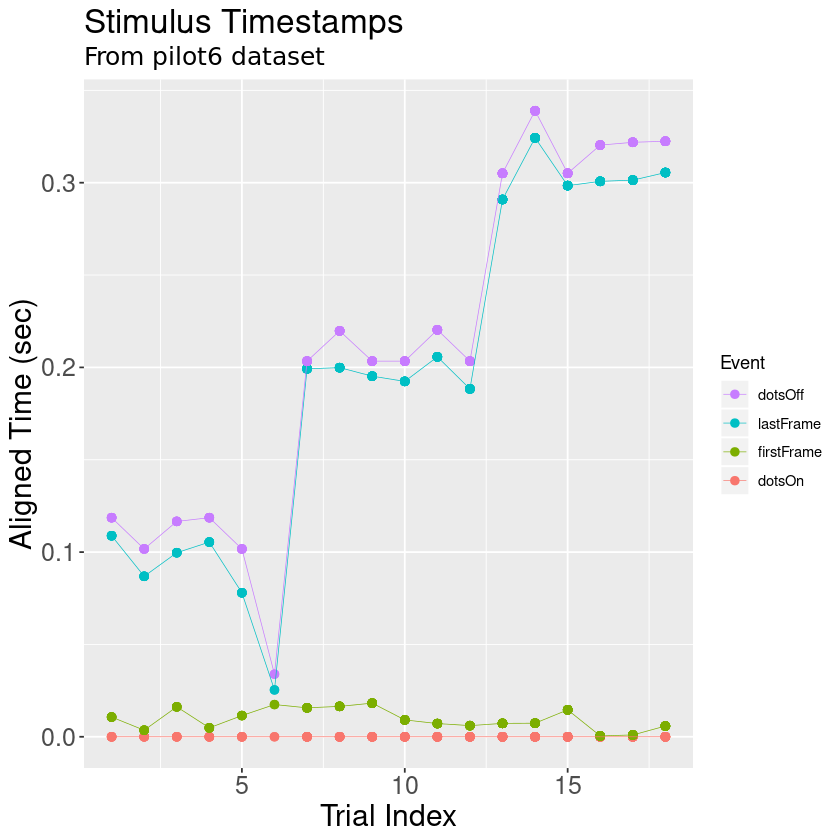

In [17]:
# transform to long format for ggplot 
longTimeData <- melt(extremeFrameTimes, 
                    id.vars=c("trialIndex"),
                    measure.vars=c("dotsOn","firstFrame","lastFrame","dotsOff"),
                    variable.name="Event", value.name="timestamp")
#str(longTimeData)

frameRate <- 60 # rounded estimate obtained from dotsTheScreen.windowFrameRate
frameDuration <- (1 / frameRate) # in msec
frameDurations <- c(6*frameDuration, 140*frameDuration)

# plot
ggplot(longTimeData, aes(x=trialIndex, y=timestamp)) + geom_point(aes(col=Event), size=2) +
   geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
   guides(colour = guide_legend(reverse=T)) +
   labs(title="Stimulus Timestamps",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="Aligned Time (sec)",
         x="Trial Index") + theme(plot.title=element_text(size=20,
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15,
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

- Exploration of `Tight` frames in each trial

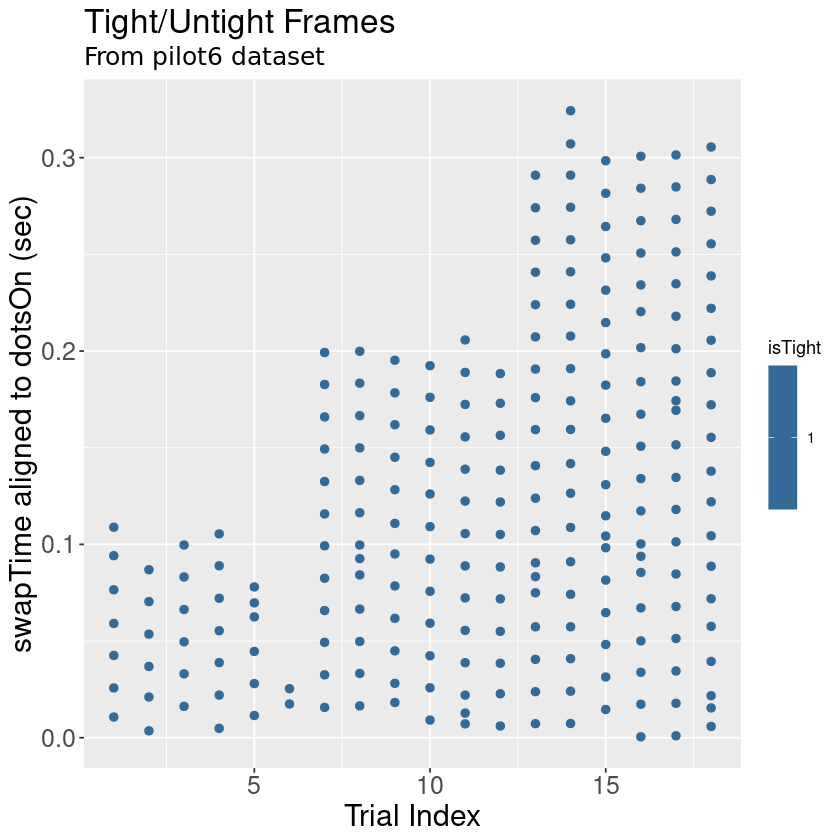

In [18]:
# plot
ggplot(frameTimes, aes(x=trialIndex, y=swapTime-dotsOn)) + geom_point(aes(col=isTight), size=2) +
#    geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
#    guides(colour = guide_legend(reverse=T)) +
   labs(title="Tight/Untight Frames",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="swapTime aligned to dotsOn (sec)",
         x="Trial Index") + theme(plot.title=element_text(size=20,
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15,
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

## Exploring match between frames and dots levels

In [19]:
length(unique(tb[[FRAMES]][,frameTotCount]))

[1] 314

In [20]:
unique(tb[[DOTS]][,frameIdx])
tb[[DOTS]][order(trialIndex),.(frameIdx), by=.(trialIndex, frameIdx)]

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21

trialIndex,frameIdx,frameIdx
1,1,1
1,2,2
1,3,3
1,4,4
1,5,5
1,6,6
1,7,7
2,1,1
2,2,2
2,3,3
